In [1]:
import os
from glob import glob
import numpy as np

from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import first, set_determinism
from monai.inferers import sliding_window_inference

import torch
import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/achilles/Workspace/Data/Task03_Liver/Data_Train_Test'
model_dir = '/home/achilles/Workspace/Data/Task03_Liver/results'

In [3]:
set_determinism(seed=0)

path_train_volumes = sorted(glob(os.path.join(data_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(data_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=["vol", "seg"], source_key="vol"),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [5]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=1)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1)

Loading dataset: 100%|████████████████████████████| 5/5 [00:22<00:00,  4.57s/it]


In [7]:
train_ds.__getitem__(0)

{'vol': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,


In [11]:
train_ds.__getitem__(0)

{'vol': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,


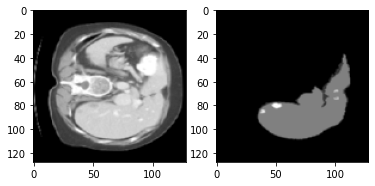

In [14]:
item = train_ds.__getitem__(0)
plt.figure("check", (6, 18))
plt.subplot(1, 2, 1)
plt.imshow(item['vol'][0, :, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(item['seg'][0, :, :, 50], cmap="gray")
plt.show()

In [7]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

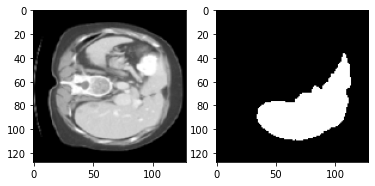

In [21]:
batch_data = first(train_loader)
volume = batch_data["vol"]
label = batch_data["seg"]
label = label != 0
plt.figure("check", (6, 18))
plt.subplot(1, 2, 1)
plt.imshow(volume[0, 0, :, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(label[0, 0, :, :, 50], cmap="gray")
plt.show()

In [8]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [9]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [10]:
# train(model, data_in, loss_function, optimizer, 100, model_dir)
best_metric = -1
best_metric_epoch = -1
save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []

In [11]:
max_epochs = 20
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    train_epoch_loss = 0
    train_step = 0
    epoch_metric_train = 0
    for batch_data in train_loader:
        train_step += 1
        
        volume = batch_data["vol"]
        label = batch_data["seg"]
        label = label != 0
        volume, label = (volume.to(device), label.to(device))

        optimizer.zero_grad()
        outputs = model(volume)
        
        train_loss = loss_function(outputs, label)
            
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        print(
            f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
            f"Train_loss: {train_loss.item():.4f}")

        train_metric = dice_metric(outputs, label)
        epoch_metric_train += train_metric
        print(f'Train_dice: {train_metric:.4f}')

    print('-'*20)

    train_epoch_loss /= train_step
    print(f'Epoch_loss: {train_epoch_loss:.4f}')
    save_loss_train.append(train_epoch_loss)
    np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

    epoch_metric_train /= train_step
    print(f'Epoch_metric: {epoch_metric_train:.4f}')

    save_metric_train.append(epoch_metric_train)
    np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

    if (epoch + 1) % 1 == 0:

        model.eval()
        with torch.no_grad():
            test_epoch_loss = 0
            test_metric = 0
            epoch_metric_test = 0
            test_step = 0

            for test_data in test_loader:

                test_step += 1

                test_volume = test_data["vol"]
                test_label = test_data["seg"]
                test_label = test_label != 0
                test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                test_outputs = model(test_volume)

                test_loss = loss_function(outputs, test_label)
                test_epoch_loss += test_loss.item()
                test_metric = dice_metric(test_outputs, test_label)
                epoch_metric_test += test_metric
         
            test_epoch_loss /= test_step
            print(f'test_loss_epoch: {test_epoch_loss:.4f}')
            save_loss_test.append(test_epoch_loss)
            np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

            epoch_metric_test /= test_step
            print(f'test_dice_epoch: {epoch_metric_test:.4f}')
            save_metric_test.append(epoch_metric_test)
            np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

            if epoch_metric_test > best_metric:
                best_metric = epoch_metric_test
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    model_dir, "best_metric_model.pth"))

            print(
                f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/20
1/20, Train_loss: 0.5451
Train_dice: 0.4549
2/20, Train_loss: 0.5665
Train_dice: 0.4335
3/20, Train_loss: 0.5640
Train_dice: 0.4360
4/20, Train_loss: 0.5591
Train_dice: 0.4409
5/20, Train_loss: 0.5464
Train_dice: 0.4536
6/20, Train_loss: 0.5767
Train_dice: 0.4233
7/20, Train_loss: 0.5664
Train_dice: 0.4336
8/20, Train_loss: 0.5622
Train_dice: 0.4378
9/20, Train_loss: 0.5604
Train_dice: 0.4396
10/20, Train_loss: 0.5666
Train_dice: 0.4334
11/20, Train_loss: 0.5806
Train_dice: 0.4194
12/20, Train_loss: 0.5545
Train_dice: 0.4455
13/20, Train_loss: 0.5601
Train_dice: 0.4399
14/20, Train_loss: 0.5632
Train_dice: 0.4368
15/20, Train_loss: 0.5574
Train_dice: 0.4426
16/20, Train_loss: 0.5723
Train_dice: 0.4277
17/20, Train_loss: 0.5622
Train_dice: 0.4378
18/20, Train_loss: 0.5633
Train_dice: 0.4367
19/20, Train_loss: 0.5624
Train_dice: 0.4376
20/20, Train_loss: 0.5679
Train_dice: 0.4321
--------------------
Epoch_loss: 0.5629
Epoch_metric: 0.4371
test_loss_epoch: 0.5508
te

In [12]:
in_dir = '/home/achilles/Workspace/Data/Task03_Liver/Data_Train_Test'
model_dir = '/home/achilles/Workspace/Data/Task03_Liver/results'

In [13]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

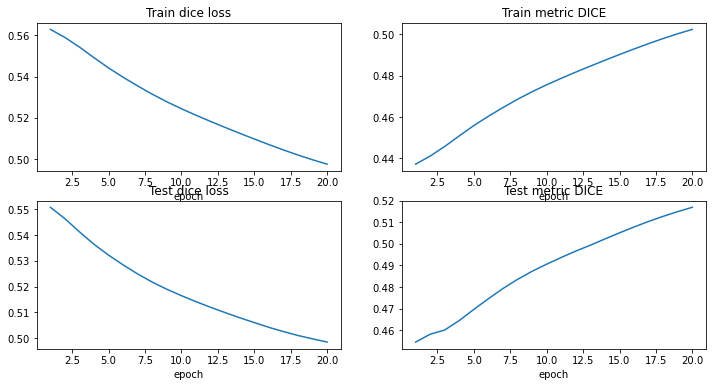

In [14]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [15]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:3]

In [16]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [17]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [18]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [19]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
# model.eval()

<All keys matched successfully>

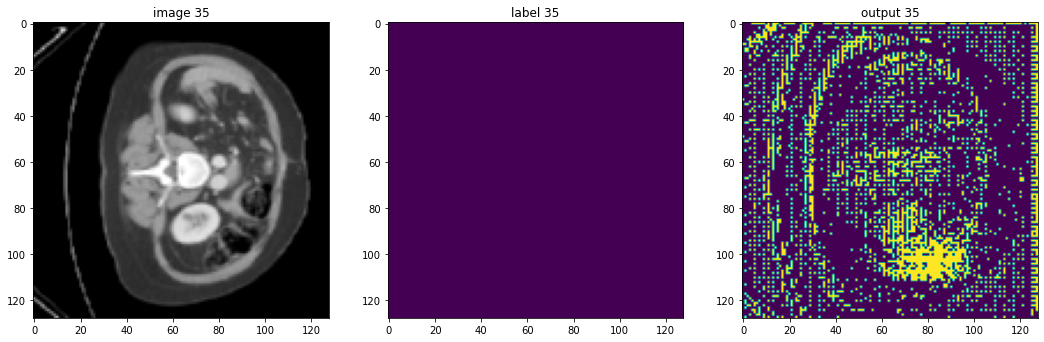

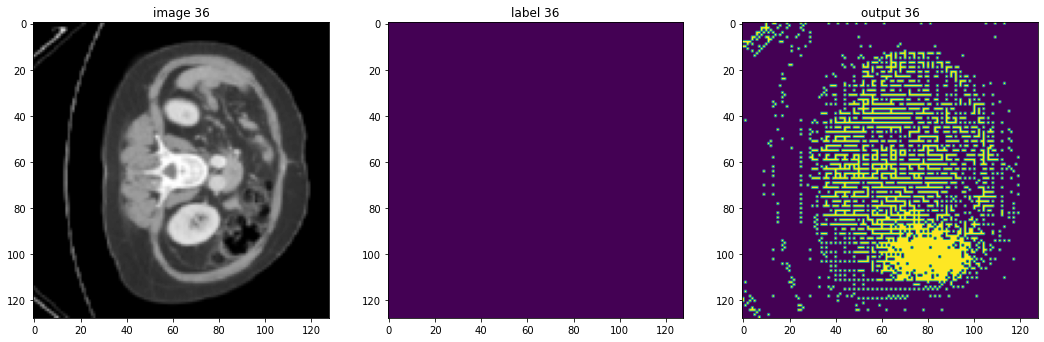

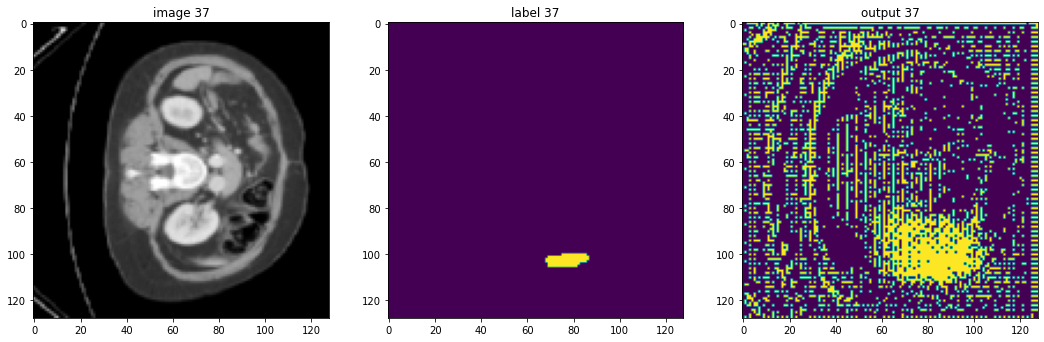

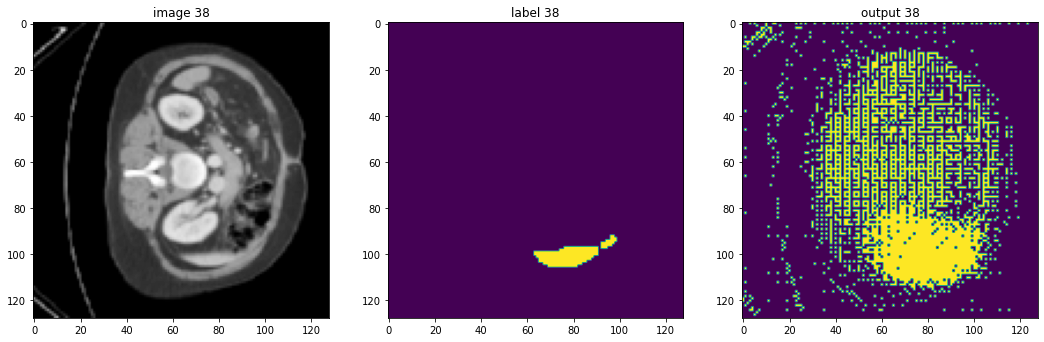

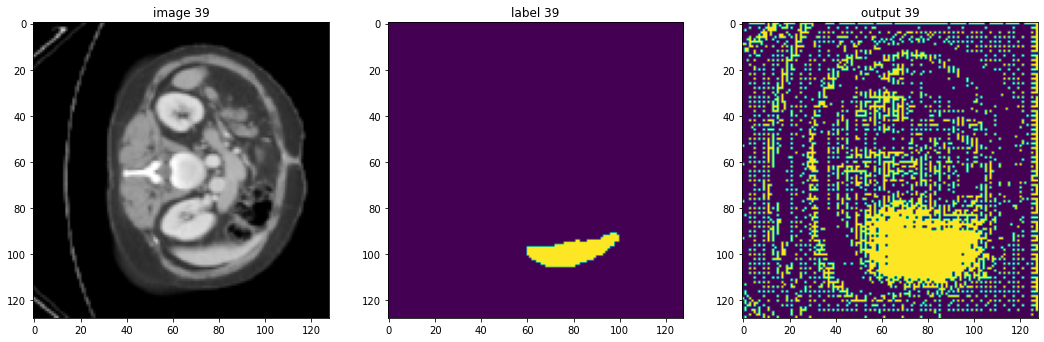

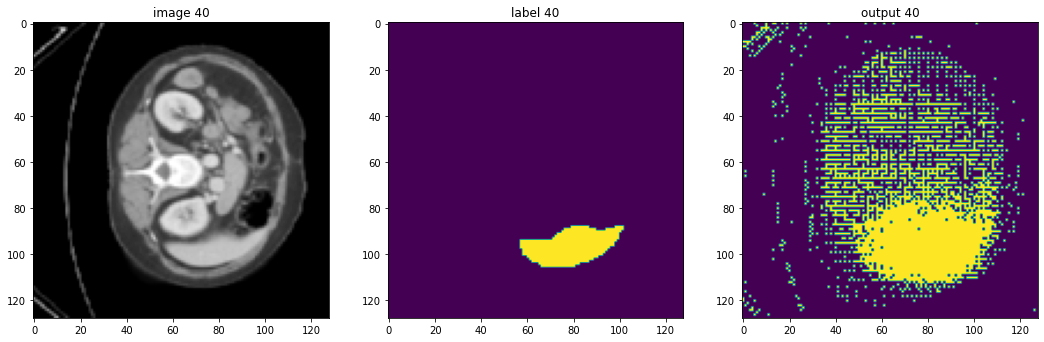

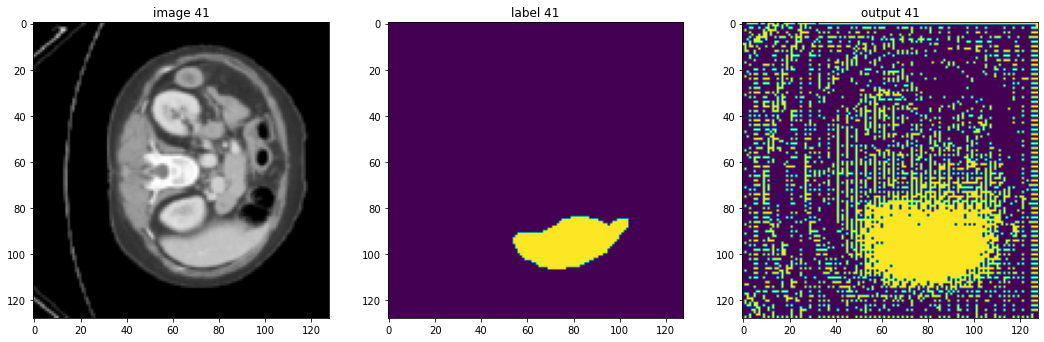

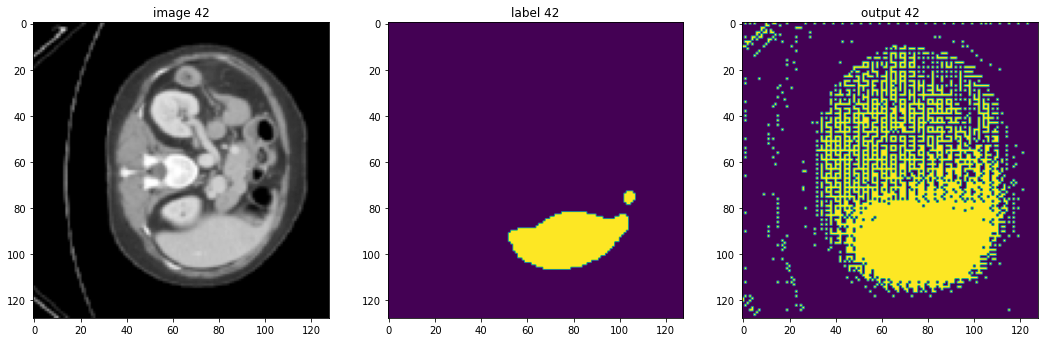

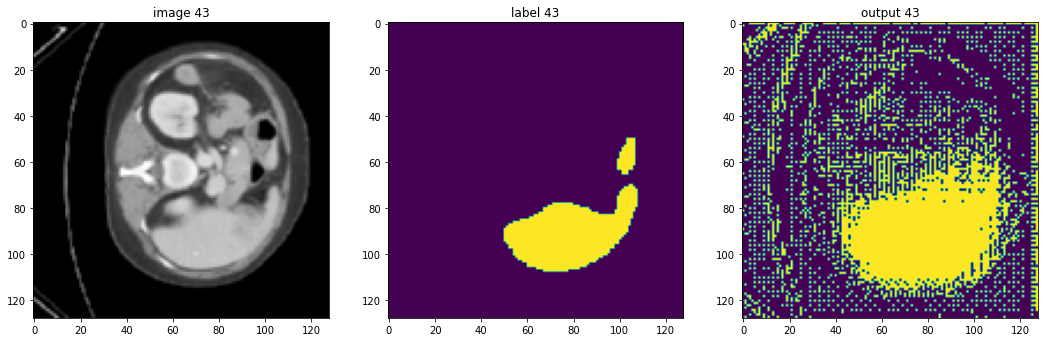

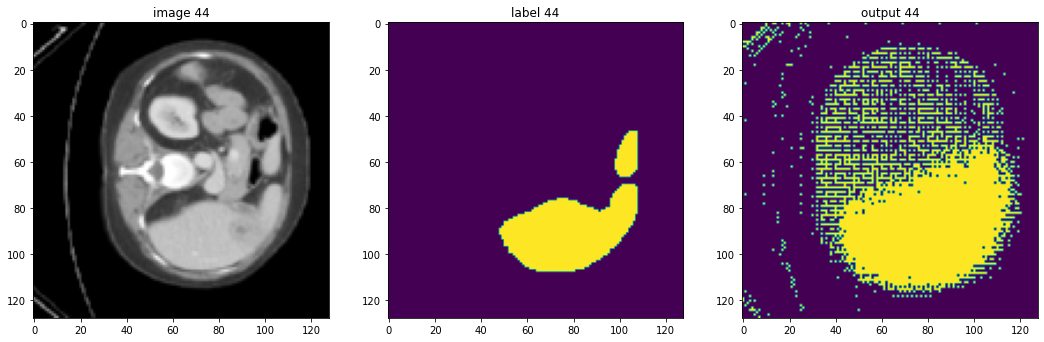

In [20]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(35, 45):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()